In [22]:
#GeoJSON file was written in the R file.
#type pip install xx into terminal for each library not installed.
#Code contained herein was written by Cody Prouty, https://scholar.google.com/citations?user=PpeDx78AAAAJ&hl=en&authuser=1
import pandas as pd
import geopandas as gpd
import os
import ee


In [13]:
polygon = gpd.read_file("Sensing.geojson")
#polygon.geometry.is_valid
#polygons are all valid

In [38]:
#earth engine needs to be authorized prior to starting.
ee.Initialize()

In [40]:
#I need to give my polygons a crs.
landplotbounds = polygon.to_crs({'init':'epsg:4326'})
#I need to know the extent of our sites
envelope = landplotbounds.geometry.total_bounds
envelope

array([-93.553261 ,  44.7679994, -92.8102368,  45.2154761])

In [266]:
#area of interest is the envelope, passing through earth engine
aoi = ee.Geometry.Rectangle([-93.553261 ,  44.7679994, -92.7702368,  45.2154761])
#collecting images from Sentinel2 mission.
Sentinel2 = ee.ImageCollection('COPERNICUS/S2').filterBounds(aoi)
#I found a date where all 3 composite images were taken
Sentinel2 = Sentinel2.filterDate('2022-07-30', '2022-07-31').filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', .1)
Sentinel2 = Sentinel2.sort('system:time_start').limit(100)

collectionList = Sentinel2.toList(Sentinel2.size())
collectionSize = collectionList.size().getInfo()

In [46]:
#band names are very important
Sentinel2.first().bandNames().getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B9',
 'B10',
 'B11',
 'B12',
 'QA10',
 'QA20',
 'QA60']

In [268]:
from IPython.display import Image
#making an image with our desired bands
parameters = {'min':0,
             'max':2000,
             'dimensions':1024,
             'bands': ['B4', 'B3', 'B2'],
             'region': aoi}
imagem1=ee.Image(collectionList.get(0)).clip(aoi)

#figuring out the exact dates when images were taken.
ee_date = ee.Date(imagem1.get('system:time_start')).format().slice(0,10);
print('Timestamp:', ee_date.getInfo())

Timestamp: 2022-07-30


In [325]:
#NDVI calculation is easily done in earth engine
NDVI = ee.Image(collectionList.get(3)).normalizedDifference(['B8', 'B4']).clip(aoi)
import geehydro
import folium
#Make a map to see NDVI across entire area of interest.
Mapa = folium.Map(location=[45.2154761, -92.7702368], zoom_start=9)

palette = ['red', 'yellow', 'green']
ndvi_parameters = {'min': 0,
                  'max': 1,
                  'dimensions':2048,
                  'region': aoi,
                  'palette':palette}
Mapa.addLayer(NDVI, ndvi_parameters)

folium.GeoJson(polygon,
              name='geojson',
              ).add_to(Mapa)

Mapa

In [271]:
#Export all NDVI images to google drive.
#Files can either be downloaded or accessed through windows file system if it drive is downloaded.
for i in range(collectionSize):
    ee.batch.Export.image.toDrive(
    image = ee.Image(collectionList.get(i)).normalizedDifference(['B8', 'B4']).clip(aoi),
        folder = 'sentinel',
        fileNamePrefix = 'SENTINEL2_'+str(i),
        scale=30
    ).start()

In [292]:
import rasterio
import rasterstats
from rasterstats import zonal_stats

result = polygon

#now I am opening those images


for i in range(3):
    ndvipath=os.getcwd()+"/sentinel/SENTINEL2_"+str(i)+".tif"
    ndvix=rasterio.open(ndvipath)
    #giving them a crs
    temp = polygon.to_crs(crs=ndvix.crs.data)
    
    array = ndvix.read(1)
    affine = ndvix.transform
    #and calculating their stats
    zs_ndvix = zonal_stats(temp,array, affine=affine, stats=['min', 'max', 'mean', 'std'])
    
    #Then exporting the stats in a dataframe
    ndviframe = pd.DataFrame(zs_ndvix)
    result = result.join(ndviframe, rsuffix='_'+str(i))

/home/cody/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/cody/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/cody/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making

In [295]:
#Write that dataframe to a csv
result.to_csv('result.csv')

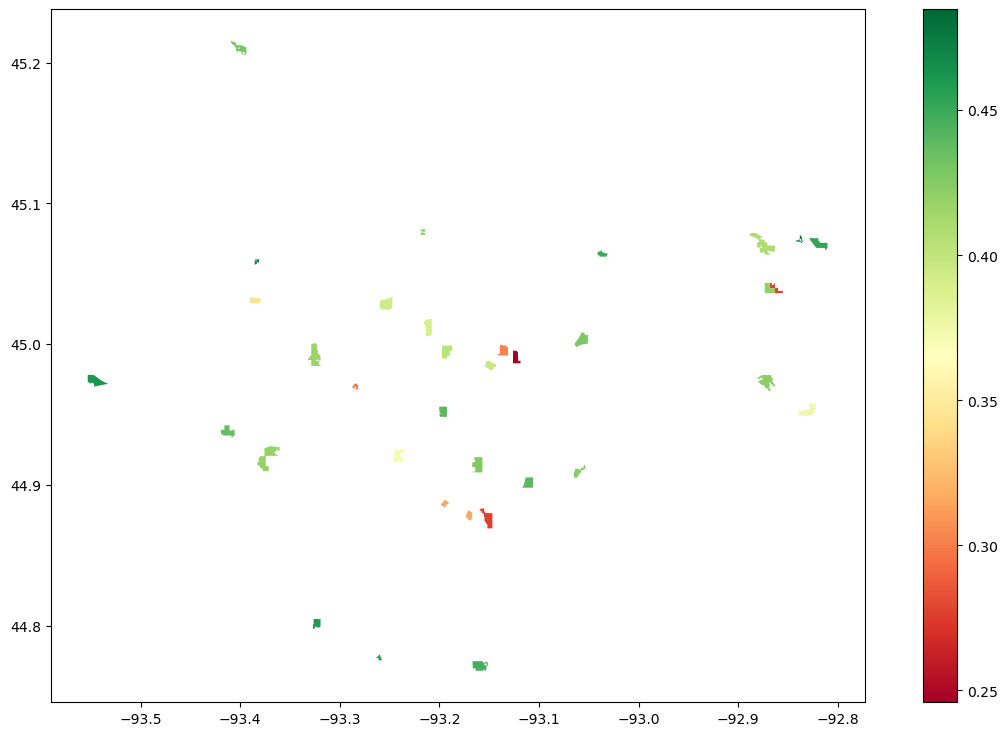

In [322]:
#Each image put out a separate column, so I needed to combine the desired columns into one.
#Problem is that some sites overlap with more than 1 image, but the total range is better on a specific image
#So its not null columns.
#I combined them by hand in excel, sue me.
from geopandas import GeoDataFrame
from shapely import wkt
result1 = pd.read_csv('result.csv')
result1['geometry'] = result1['geometry'].apply(wkt.loads)
crs = {'init': 'epsg:4326'}
resultgpd = gpd.GeoDataFrame(result1, crs=crs)

#Made a map of the NDVI
meanmap = resultgpd.plot(column='mean', cmap = 
                     'RdYlGn', figsize=(15,9), legend = 
                     True);
#Output this into a geojson file for later use.
resultgpd.to_crs({'init':'epsg:31983'}).to_file("ZonalStatsNDVI_Polygons.geojson", driver='GeoJSON')

,Unnamed: 0,LUSE2020,DESC2020,Shape_Leng,ACRES,Shape_Le_1,Shape_Area,Code,Beetles,ï..Site,...,Rotation,Contact,Email,min,max,mean,std,Phone,Address,geometry
0,0,100,Agricultural,1.628433e+07,543694.89950,1.628433e+07,2.200255e+09,SV,600.20,St. Croix Vineyards,...,Tues/2,Brian Bohl,NaN,0.029455,0.513961,0.277015,0.099837,NaN,"6200 Interlachen Blvd, Minneapolis, MN 55436","POLYGON ((-92.86607870000002 45.0433878, -92.8..."
1,1,173,Golf Course,6.841531e+05,19974.90032,6.841531e+05,8.083555e+07,ME,2186.15,Meadowbrook,...,Mon/3,Corey Heasley,corey@foxhollowgolf.net,0.037736,0.593212,0.418813,0.117439,763-428-8449,"4780 Palmgren Ln NE, St Michael, MN 55376","POLYGON ((-93.3642309 44.9270908, -93.3648853 ..."
2,2,173,Golf Course,6.841531e+05,19974.90032,6.841531e+05,8.083555e+07,LT,4201.00,Loggers Trail,...,Tues/2,NaN,NaN,0.065296,0.591802,0.409224,0.097613,NaN,"11000 Bass Lake Rd, Plymouth, MN 55442","POLYGON ((-92.8768593 45.0764162, -92.8770235 ..."
3,3,173,Golf Course,6.841531e+05,19974.90032,6.841531e+05,8.083555e+07,TW,353.75,Theodore Wirth,...,Mon/3,Shannon Young,syoung@southstpaul.org,0.051603,0.563796,0.417319,0.086210,651-554-3201,125 Third Ave N South St. Paul,"POLYGON ((-93.3261132 45.0005315, -93.3261114 ..."
4,4,173,Golf Course,6.841531e+05,19974.90032,6.841531e+05,8.083555e+07,RY,1403.45,Royal,...,Tues/2,Bill Vollbrecht,NaN,0.073384,0.604179,0.422690,0.106833,NaN,"10100 Normandale Blvd, Bloomington, MN 55437","POLYGON ((-92.8729237 44.9780559, -92.873006 4..."
5,5,173,Golf Course,6.841531e+05,19974.90032,6.841531e+05,8.083555e+07,CO,768.90,Columbia GC,...,Mon/2,Daniel Rootes,daniel.rootes@burnsvillemn.gov,0.066351,0.575070,0.393817,0.104978,Pro-shop:\n952-641-1370,"12424 Parkwood Dr, Burnsville, MN 55337","POLYGON ((-93.2472619 45.0331558, -93.2472557 ..."
6,6,173,Golf Course,6.841531e+05,19974.90032,6.841531e+05,8.083555e+07,HN,866.50,Highland Nat.,...,Thurs/2,NaN,NaN,0.058998,0.579966,0.426020,0.108860,320-492-4333,"1431 Lexington Pkwy N, St Paul, MN 55103","POLYGON ((-93.1593852 44.9196952, -93.1619332 ..."
7,7,173,Golf Course,6.841531e+05,19974.90032,6.841531e+05,8.083555e+07,WH,4074.85,Woodhill CC,...,Mon/3,NaN,NaN,0.037261,0.595256,0.461462,0.084273,NaN,"1382 Willow St.\nMinneapolis, MN 55403","POLYGON ((-93.5532277 44.9781777, -93.5532369 ..."
8,8,173,Golf Course,6.841531e+05,19974.90032,6.841531e+05,8.083555e+07,VW,446.85,Valleywood,...,Thurs/2,NaN,NaN,0.046489,0.601248,0.446913,0.103748,NaN,"3933 E Minnehaha Pkwy, Minneapolis, MN 55417","POLYGON ((-93.1570139 44.7748317, -93.1574681 ..."
9,9,173,Golf Course,6.841531e+05,19974.90032,6.841531e+05,8.083555e+07,SR,515.40,Stone Ridge,...,Tues/2,NaN,NaN,0.031234,0.582453,0.375475,0.117762,NaN,NaN,"POLYGON ((-92.8284663 44.9578041, -92.8286541 ..."
